<a href="https://colab.research.google.com/github/dgim0521-ai/numerical-analysis-2025/blob/main/Rain_free_days_LDC_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# NanumGothic 폰트 설치
!sudo apt-get install -y fonts-nanum

# 폰트 캐시를 지우고 다시 빌드합니다.
# 이렇게 해야 Matplotlib이 새로 설치된 폰트를 인식할 수 있습니다.
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

# 런타임 재시작을 권장하는 경우도 있지만, 여기서는 캐시만 지워도 될 확률이 높습니다.
# 확실한 적용을 위해서는 런타임 재시작 후 이전 셀을 다시 실행하는 것이 가장 좋습니다.
print("NanumGothic 폰트 설치 및 캐시 업데이트 완료. 이전 LDC 분석 셀을 다시 실행해주세요.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 1 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (44.5 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 117528 files and direct


--- Flow Regime Analysis ---
Flow Regime  Total Data Points  Exceeding Target Load Exceedance Percentage
        풍수기                 40                     10                25.00%
        평수기                 20                      6                30.00%
        저수기                 30                     13                43.33%
        갈수기                 11                     10                90.91%
--------------------------

표 분석 결과가 'Flow_Regime_Analysis_7days.png' 파일로 저장되었습니다.
그래프 분석 결과가 'LDC_RainFree_7days_FlowRegime.png' 파일로 저장되었습니다.


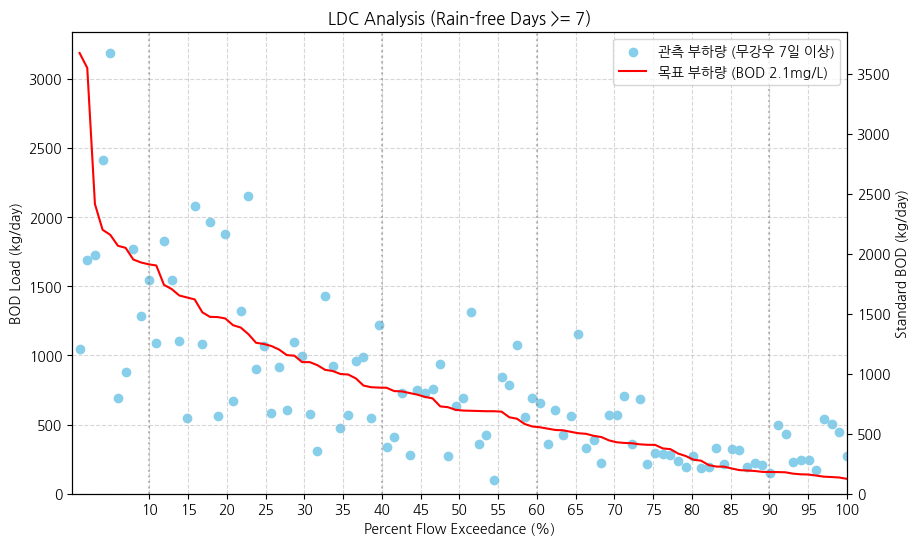

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.font_manager as fm # font_manager import
# import dataframe_image as dfi # dataframe_image import - Removed as it causes issues
# import nest_asyncio # nest_asyncio import - Removed as it causes issues

# nest_asyncio.apply() # Apply nest_asyncio to allow synchronous Playwright calls in Colab environment - Removed as it causes issues

# NanumGothic 폰트 경로 설정 및 등록
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path);
    # 폰트 캐시 재빌드 (필요한 경우)
    plt.rcParams['font.family'] = 'NanumGothic';
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
else:
    print(f"Warning: NanumGothic font not found at {font_path}. Using default font.");
    plt.rcParams["font.family"] = "sans-serif"

def analyze_ldc_with_prior_dry_days(flow_bod_file, precip_file, target_bod=2.1, threshold=7):
    # 1. 환경 설정 (함수 내에서는 전역 설정에 따르도록 변경)
    # plt.rcParams["font.family"]는 이미 상위 코드에서 NanumGothic으로 설정되었습니다.
    # plt.rcParams["axes.unicode_minus"] = False # 이 설정도 이미 상위 코드에서 처리되었습니다.

    # 2. 데이터 로드 (날짜 형식 변환 필수)
    # encoding='euc-kr' 추가
    df_wq = pd.read_csv(flow_bod_file, encoding='euc-kr') # 수질 데이터 (6~8일 간격)
    df_pr = pd.read_csv(precip_file, encoding='euc-kr')   # 강수량 데이터 (1일 간격)

    # 헤더 이름은 실제 CSV에 맞춰 수정하세요 (Date, BOD, Flow, Precip)
    df_wq['Date'] = pd.to_datetime(df_wq['Date'])
    df_pr['Date'] = pd.to_datetime(df_pr['Date'])
    df_pr = df_pr.sort_values('Date') # 강수량은 날짜순 정렬 필수

    # 3. 측정일 기준 사전 무강우 일수 계산 로직
    def get_dry_days(measurement_date):
        # 측정일 이전의 강수 데이터만 필터링
        prior_rain = df_pr[df_pr['Date'] < measurement_date].sort_values('Date', ascending=False)
        count = 0
        for _, row in prior_rain.iterrows():
            if row['Precip'] >= 10: # 비가 온 날(10mm 이상)을 만나면 정지
                break
            count += 1
        return count

    # 수질 측정 데이터 각각에 대해 무강우 일수 계산 적용
    df_wq['Rain_free_days'] = df_wq['Date'].apply(get_dry_days)

    # 4. 필터링 (무강우 threshold 이상 지속된 경우)
    df_filtered = df_wq[df_wq['Rain_free_days'] >= threshold].copy()

    if df_filtered.empty:
        print(f"조건(무강우 {threshold}일 이상)을 만족하는 데이터가 없습니다.")
        return

    # 5. LDC 계산 및 시각화
    df_filtered = df_filtered.sort_values(by='Flow', ascending=False).reset_index(drop=True)
    n = len(df_filtered)
    df_filtered['Exceed_Prob'] = (pd.Series(range(1, n + 1)) / n) * 100
    df_filtered['Target_Load'] = df_filtered['Flow'] * target_bod * 86.4
    df_filtered['Observed_Load'] = df_filtered['Flow'] * df_filtered['BOD'] * 86.4

    # Categorize 'Flow_Regime'
    # '풍수기': (0, 40] (inclusive of 0 and 40)
    # '평수기': (40, 60]
    # '저수기': (60, 90]
    # '갈수기': (90, 100]
    bins = [0, 40, 60, 90, 100]
    labels = ['풍수기', '평수기', '저수기', '갈수기']
    df_filtered['Flow_Regime'] = pd.cut(df_filtered['Exceed_Prob'], bins=bins, labels=labels, right=True, include_lowest=True)

    # Create a DataFrame for flow regime analysis
    regime_data = []
    # Ensure all defined regimes are covered, even if no data points fall into them
    all_regimes = ['풍수기', '평수기', '저수기', '갈수기']
    for regime in all_regimes:
        regime_df = df_filtered[df_filtered['Flow_Regime'] == regime]
        total_points = len(regime_df)
        exceeding_points = len(regime_df[regime_df['Observed_Load'] > regime_df['Target_Load']])
        exceedance_percentage = (exceeding_points / total_points * 100) if total_points > 0 else 0
        regime_data.append({
            'Flow Regime': regime,
            'Total Data Points': total_points,
            'Exceeding Target Load': exceeding_points,
            'Exceedance Percentage': f'{exceedance_percentage:.2f}%'
        })
    df_regime_analysis = pd.DataFrame(regime_data)

    print("\n--- Flow Regime Analysis ---")
    print(df_regime_analysis.to_string(index=False))
    print("--------------------------\n")

    # Save DataFrame as image with center alignment using Matplotlib
    fig_table, ax_table = plt.subplots(figsize=(10, 2)) # Adjust figure size as needed
    ax_table.axis('off') # Hide axes
    table = ax_table.table(cellText=df_regime_analysis.values,
                            colLabels=df_regime_analysis.columns,
                            loc='center')

    # Style the table for center alignment
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    for (row, col), cell in table.get_celld().items():
        cell.set_text_props(ha='center')

    table_file_name = f'Flow_Regime_Analysis_{threshold}days.png'
    plt.savefig(table_file_name, dpi=300, bbox_inches='tight')
    plt.close(fig_table) # Close the table figure to prevent it from displaying
    print(f"표 분석 결과가 '{table_file_name}' 파일로 저장되었습니다.")


    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 왼쪽 y축 (Observed Load)
    ax1.scatter(df_filtered['Exceed_Prob'], df_filtered['Observed_Load'], color='skyblue', label=f'관측 부하량 (무강우 {threshold}일 이상)')
    ax1.set_xlabel('Percent Flow Exceedance (%)')
    ax1.set_ylabel('BOD Load (kg/day)')
    ax1.set_title(f'LDC Analysis (Rain-free Days >= {threshold})')
    ax1.set_xlim(0, 100)
    ax1.set_xticks(range(10, 101, 5)) # Set x-axis ticks from 10 to 100 in increments of 5
    ax1.set_ylim(bottom=0)

    # 오른쪽 y축 (Target Load)
    ax2 = ax1.twinx() # 보조 y축 생성
    ax2.plot(df_filtered['Exceed_Prob'], df_filtered['Target_Load'], color='red', label=f'목표 부하량 (BOD {target_bod}mg/L)')
    ax2.set_ylabel('Standard BOD (kg/day)') # 오른쪽 y축 라벨
    ax2.set_ylim(bottom=0) # 동일한 하한 값 유지

    # 범례 합치기
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    # 유황 구분선 추가
    ax1.axvline(x=10, color='gray', linestyle=':', alpha=0.5, label='풍수기 경계 (10%)')
    ax1.axvline(x=40, color='gray', linestyle=':', alpha=0.5, label='평수기 경계 (40%)')
    ax1.axvline(x=60, color='gray', linestyle=':', alpha=0.5, label='저수기 경계 (60%)') # Updated boundary
    ax1.axvline(x=90, color='gray', linestyle=':', alpha=0.5, label='갈수기 경계 (90%)') # New boundary

    ax1.grid(True, which='both', linestyle='--', alpha=0.5);

    file_name = f'LDC_RainFree_{threshold}days_FlowRegime.png' # Changed filename to reflect new analysis
    plt.savefig(file_name, dpi=300)
    print(f"그래프 분석 결과가 '{file_name}' 파일로 저장되었습니다.")
    plt.show()

# 실행 예시
# analyze_ldc_with_prior_dry_days('wq_data.csv', 'precip_data.csv', threshold=14)

# 1. 유량과 BOD 데이터 파일 경로 (6~8일 간격) - 경로 수정
flow_bod_path = '/content/유량,bod 데이터.csv'

# 2. 강수량 데이터 파일 경로 (1일 간격) - 경로 수정
precip_path = '/content/강수량 데이터.csv'

# 함수 호출: 무강우 14일 이상 지속 조건을 만족하는 데이터로 LDC 분석
analyze_ldc_with_prior_dry_days(
    flow_bod_file=flow_bod_path,
    precip_file=precip_path,
    threshold=7 # 무강우 14일 이상 데이터만 필터링
)

위 셀을 실행하여 폰트 설치 및 캐시 업데이트를 완료한 후, 이전에 LDC 분석을 수행했던 코드 셀을 다시 실행하시면 한글 폰트가 정상적으로 표시될 것입니다.